# Problem 1

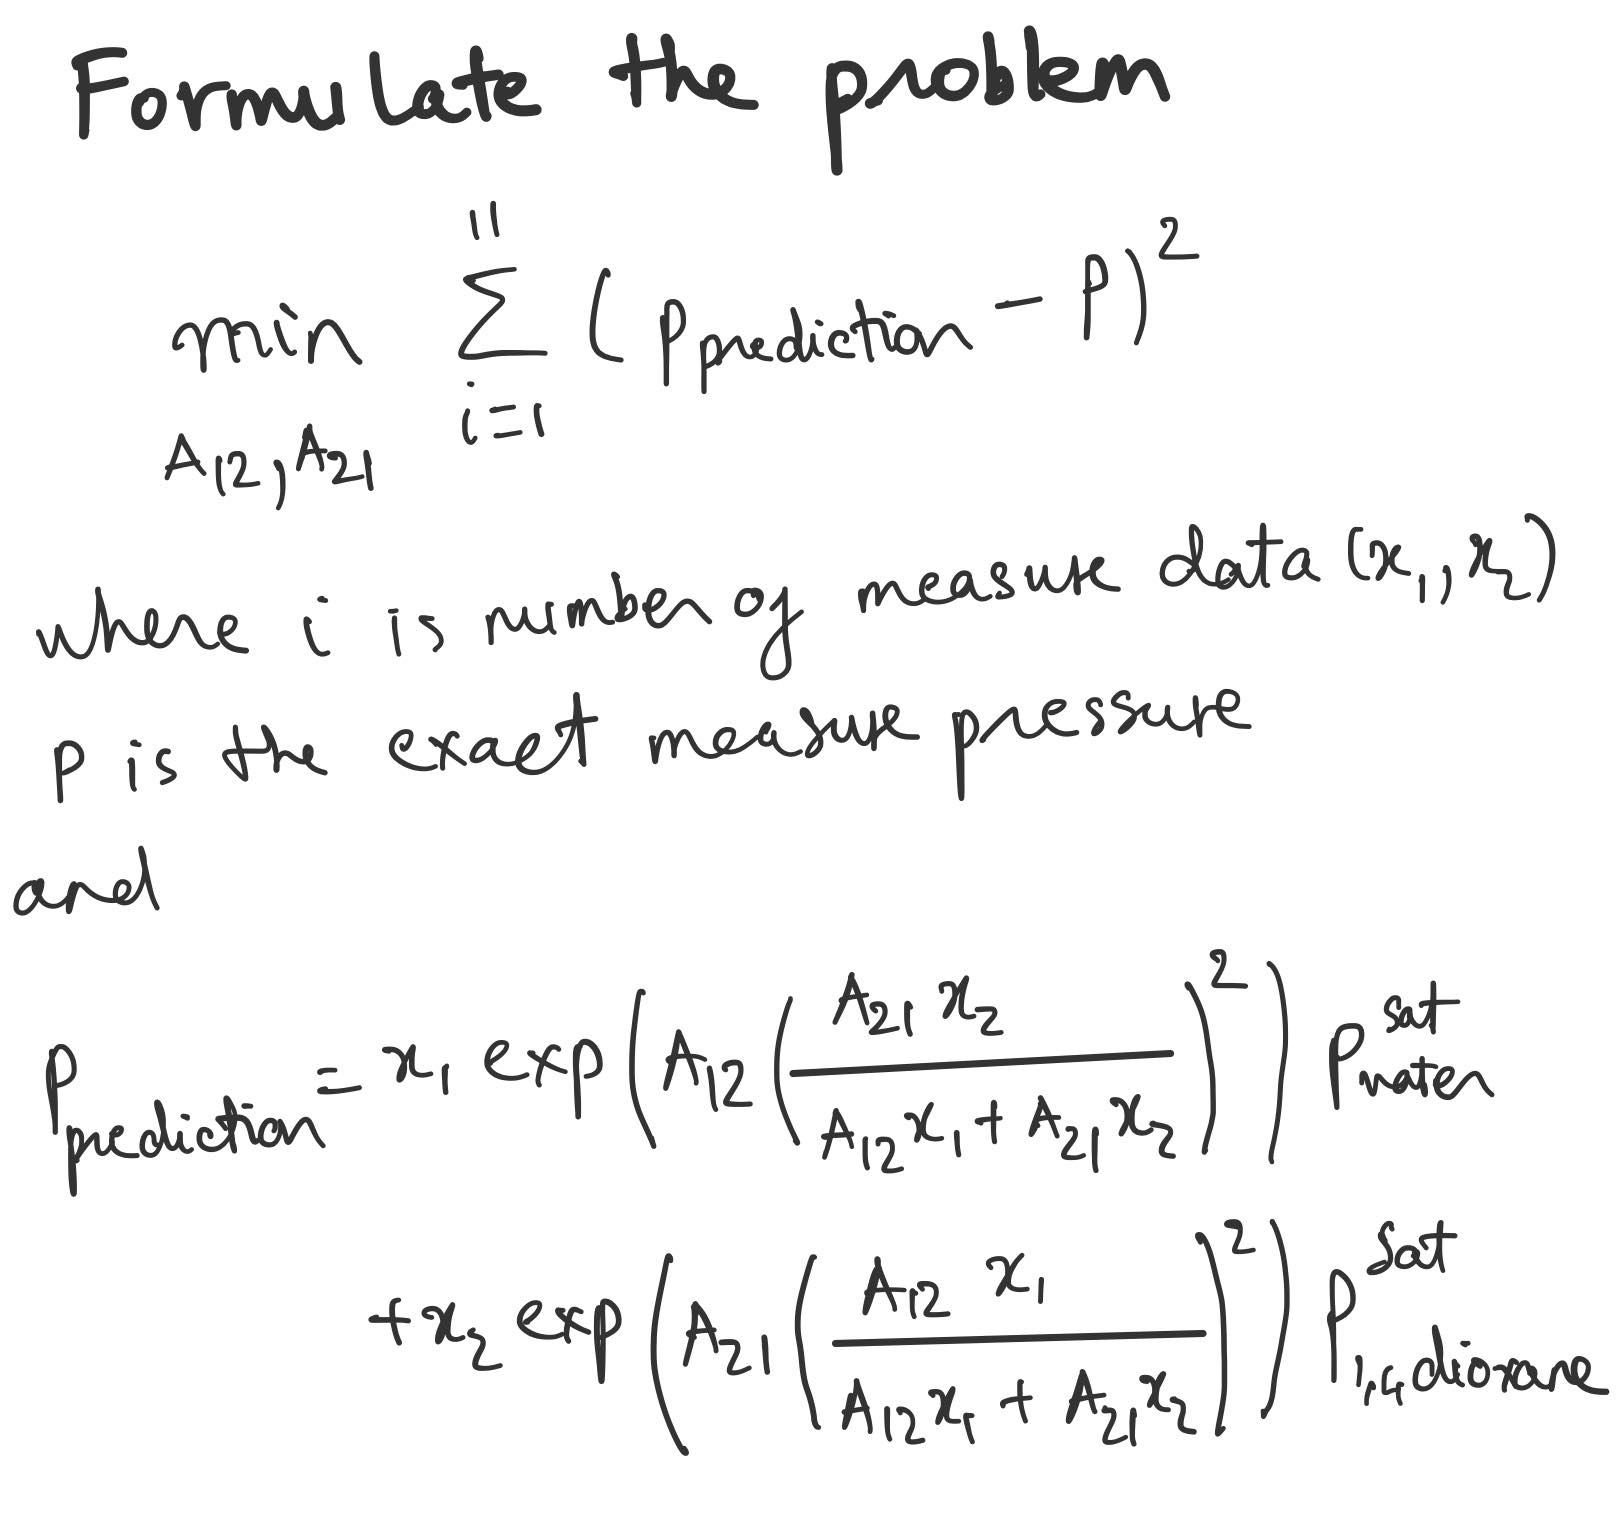

In [56]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [57]:
import torch
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt
from IPython import display

In [58]:
X1 = np.linspace(0,1,11)
X2 = np.flip(X1).copy()
a = np.array([[8.07131,1730.63,233.426],[7.43155,1554.679,240.337]])
T = 20
p_sat_water = 10**(a[0,0]-(a[0,1]/(T+a[0,2])))
p_sat_dioxane = 10**(a[1,0]-(a[1,1]/(T+a[1,2])))
P_label = np.array([[28.1, 34.4, 36.7, 36.9, 36.8, 36.7, 36.5, 35.4, 32.9, 27.7, 17.5]])
P_label = torch.tensor(P_label,dtype=torch.float32)
x1 = torch.tensor(X1,dtype=torch.float32)
x2 = torch.tensor(X2,dtype=torch.float32)
A = Variable(torch.tensor([1.0, 1.0]), requires_grad=True)
a=0.0001

for i in range(1000):

    p_pred = x1 * torch.exp(A[0] * (A[1] * x2 / (A[0] * x1 + A[1] * x2)) ** 2) * p_sat_water + \
        x2 * torch.exp(A[1] * (A[0] * x1 / (A[0] * x1 + A[1] * x2)) ** 2) * p_sat_dioxane
    
    loss = (p_pred-P_label)**2
    loss = loss.sum()
    loss.backward()
    
    with torch.no_grad():
        A -= a*A.grad
        A.grad.zero_()
        
print('Optimal variables A12 and A21 are:',A)
print('loss is:',loss.data.numpy())

Optimal variables A12 and A21 are: tensor([1.9584, 1.6892], requires_grad=True)
loss is: 0.67018914


In [59]:
p_pred = p_pred.detach().numpy()
P_label = P_label.detach().numpy()[0]
x1 = x1.detach().numpy()
x2 = x2.detach().numpy()

print("p_pred",p_pred)
print("P_label",P_label)
print("x1",x1)

p_pred [28.824099 34.644295 36.452957 36.867302 36.873997 36.749832 36.39045
 35.384827 32.9478   27.730024 17.473251]
P_label [28.1 34.4 36.7 36.9 36.8 36.7 36.5 35.4 32.9 27.7 17.5]
x1 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


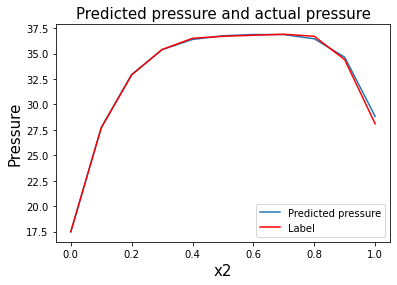

In [60]:
plt.plot(x2,p_pred,label="Predicted pressure")  
plt.plot(x2,P_label,label='Label',color='red')
plt.xlabel('x2',size=15)
plt.ylabel('Pressure',size=15)
plt.legend()
plt.title('Predicted pressure and actual pressure',size=15)
plt.show()

# Problem 2

In [61]:
import numpy as np
import scipy as sp
from scipy import linalg
from scipy import optimize
from scipy import interpolate
import sympy as sm

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [68]:

x1 = sm.symbols('x_1')
x2 = sm.symbols('x_2')
f = (4-2.1*x1**2 + (x1**4)/3)*x1**2 + x1*x2 + (4*x2**2 - 4)*x2**2
# _f = sm.lambdify((x1,x2),f)
f

x_1**2*(x_1**4/3 - 2.1*x_1**2 + 4) + x_1*x_2 + x_2**2*(4*x_2**2 - 4)

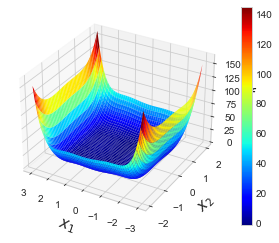

In [69]:
x1_vec = np.linspace(-3,3,500)
x2_vec = np.linspace(-2,2,500)
x1_grid,x2_grid = np.meshgrid(x1_vec,x2_vec,indexing='ij')
f_grid = _f(x1_grid,x2_grid)

fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.plot_surface(x1_grid,x2_grid,f_grid,cmap=cm.jet)

ax.set_xlabel('$x_1$',size=15)
ax.set_ylabel('$x_2$',size=15)
ax.set_zlabel('$f$',size=15)

ax.invert_xaxis()

fig.colorbar(cs);

In [70]:
""" 
Bayesian optimisation of loss functions.
"""

import numpy as np
import sklearn.gaussian_process as gp

from scipy.stats import norm
from scipy.optimize import minimize

def expected_improvement(x, gaussian_process, evaluated_loss, greater_is_better=False, n_params=1):
    """ expected_improvement

    Expected improvement acquisition function.

    Arguments:
    ----------
        x: array-like, shape = [n_samples, n_hyperparams]
            The point for which the expected improvement needs to be computed.
        gaussian_process: GaussianProcessRegressor object.
            Gaussian process trained on previously evaluated hyperparameters.
        evaluated_loss: Numpy array.
            Numpy array that contains the values off the loss function for the previously
            evaluated hyperparameters.
        greater_is_better: Boolean.
            Boolean flag that indicates whether the loss function is to be maximised or minimised.
        n_params: int.
            Dimension of the hyperparameter space.

    """

    x_to_predict = x.reshape(-1, n_params)

    mu, sigma = gaussian_process.predict(x_to_predict, return_std=True)

    if greater_is_better:
        loss_optimum = np.max(evaluated_loss)
    else:
        loss_optimum = np.min(evaluated_loss)

    scaling_factor = (-1) ** (not greater_is_better)

    # In case sigma equals zero
    with np.errstate(divide='ignore'):
        Z = scaling_factor * (mu - loss_optimum) / sigma
        expected_improvement = scaling_factor * (mu - loss_optimum) * norm.cdf(Z) + sigma * norm.pdf(Z)
        expected_improvement[sigma == 0.0] == 0.0

    return -1 * expected_improvement


def sample_next_hyperparameter(acquisition_func, gaussian_process, evaluated_loss, greater_is_better=False,
                               bounds=(0, 10), n_restarts=25):
    """ sample_next_hyperparameter

    Proposes the next hyperparameter to sample the loss function for.

    Arguments:
    ----------
        acquisition_func: function.
            Acquisition function to optimise.
        gaussian_process: GaussianProcessRegressor object.
            Gaussian process trained on previously evaluated hyperparameters.
        evaluated_loss: array-like, shape = [n_obs,]
            Numpy array that contains the values off the loss function for the previously
            evaluated hyperparameters.
        greater_is_better: Boolean.
            Boolean flag that indicates whether the loss function is to be maximised or minimised.
        bounds: Tuple.
            Bounds for the L-BFGS optimiser.
        n_restarts: integer.
            Number of times to run the minimiser with different starting points.

    """
    best_x = None
    best_acquisition_value = 1
    n_params = bounds.shape[0]

    for starting_point in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, n_params)):

        res = minimize(fun=acquisition_func,
                       x0=starting_point.reshape(1, -1),
                       bounds=bounds,
                       method='L-BFGS-B',
                       args=(gaussian_process, evaluated_loss, greater_is_better, n_params))

        if res.fun < best_acquisition_value:
            best_acquisition_value = res.fun
            best_x = res.x

    return best_x


def bayesian_optimisation(n_iters, sample_loss, bounds, x0=None, n_pre_samples=5,
                          gp_params=None, random_search=False, alpha=1e-5, epsilon=1e-7):
    """ bayesian_optimisation

    Uses Gaussian Processes to optimise the loss function `sample_loss`.

    Arguments:
    ----------
        n_iters: integer.
            Number of iterations to run the search algorithm.
        sample_loss: function.
            Function to be optimised.
        bounds: array-like, shape = [n_params, 2].
            Lower and upper bounds on the parameters of the function `sample_loss`.
        x0: array-like, shape = [n_pre_samples, n_params].
            Array of initial points to sample the loss function for. If None, randomly
            samples from the loss function.
        n_pre_samples: integer.
            If x0 is None, samples `n_pre_samples` initial points from the loss function.
        gp_params: dictionary.
            Dictionary of parameters to pass on to the underlying Gaussian Process.
        random_search: integer.
            Flag that indicates whether to perform random search or L-BFGS-B optimisation
            over the acquisition function.
        alpha: double.
            Variance of the error term of the GP.
        epsilon: double.
            Precision tolerance for floats.
    """

    x_list = []
    y_list = []

    n_params = bounds.shape[0]

    if x0 is None:
        for params in np.random.uniform(bounds[:, 0], bounds[:, 1], (n_pre_samples, bounds.shape[0])):
            x_list.append(params)
            y_list.append(sample_loss(params))
            # print()
    else:
        for params in x0:
            x_list.append(params)
            y_list.append(sample_loss(params))

    xp = np.array(x_list)
    yp = np.array(y_list)

    # Create the GP
    if gp_params is not None:
        model = gp.GaussianProcessRegressor(**gp_params)
    else:
        kernel = gp.kernels.Matern()
        model = gp.GaussianProcessRegressor(kernel=kernel,
                                            alpha=alpha,
                                            n_restarts_optimizer=10,
                                            normalize_y=True)

    for n in range(n_iters):

        model.fit(xp, yp)

        # Sample next hyperparameter
        if random_search:
            x_random = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(random_search, n_params))
            ei = -1 * expected_improvement(x_random, model, yp, greater_is_better=True, n_params=n_params)
            next_sample = x_random[np.argmax(ei), :]
        else:
            next_sample = sample_next_hyperparameter(expected_improvement, model, yp, greater_is_better=True, bounds=bounds, n_restarts=100)

        # Duplicates will break the GP. In case of a duplicate, we will randomly sample a next query point.
        if np.any(np.abs(next_sample - xp) <= epsilon):
            next_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], bounds.shape[0])

        # Sample loss for new set of parameters
        cv_score = sample_loss(next_sample)

        # Update lists
        x_list.append(next_sample)
        y_list.append(cv_score)

        # Update xp and yp
        xp = np.array(x_list)
        yp = np.array(y_list)

    return xp, yp

def sample_loss(params):
    """
    objective function definition
    """
    return (4 - 2.1 * params[0] ** 2 + params[0] ** 4 / 3) * params[0] ** 2 + params[0] * params[1] + (-4 + 4 * params[1] ** 2) * params[1] ** 2

bounds = np.array([[-3, 3], [-2, 2]])

xp, yp = bayesian_optimisation(n_iters=30,
                               sample_loss=sample_loss,
                               bounds=bounds,
                               n_pre_samples=20,
                               random_search=100000)

print('minimum objective function:', np.min(yp))
print('x1, x2 when having minumum objective function:',xp[np.argmin(yp)])
print('solution x1, x2:', xp)
print('objective function:', yp)

C:\Users\USER\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:509: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\USER\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:509: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


minimum objective function: -0.19720659701802745
x1, x2 when having minumum objective function: [-0.15788957  0.26125069]
solution x1, x2: [[ 0.94098729 -0.29409409]
 [ 1.9902789   1.16956453]
 [ 0.14074243  1.96181086]
 [ 0.39671009 -1.53126281]
 [-2.31915733  0.02252936]
 [ 1.34721524 -1.184735  ]
 [ 2.77050743 -0.46693473]
 [ 2.27251006  0.11407542]
 [-2.2479029  -0.6115344 ]
 [-0.16169734  1.89319194]
 [ 2.44705942  0.70770362]
 [ 1.67824721  1.60611177]
 [-2.31776416 -0.71023615]
 [-2.20817328 -0.87403892]
 [-2.41251135  0.59324923]
 [-1.48503374 -0.67507028]
 [-0.15788957  0.26125069]
 [-2.49187111  0.62087645]
 [-1.53621844  1.52297907]
 [-2.87981789 -0.12227312]
 [-2.99885375 -0.1228028 ]
 [-2.99392917 -0.11371453]
 [-2.99804068 -0.22643849]
 [-2.99955055 -0.42824046]
 [-2.9993964  -0.67666966]
 [-2.99934441 -1.24794155]
 [-2.99870881 -1.73941067]
 [-2.99071892 -1.9922099 ]
 [-2.77912401 -1.99663659]
 [-2.99623595 -1.99107722]
 [ 2.98637068 -1.99158557]
 [-2.99826107 -1.9975332